Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Wed May 12 03:47:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Change working directory

In [ ]:
import os
# modify the root_path to the clone directory
root_path = '/content/gdrive/MyDrive/Project'
os.chdir(root_path)

Install packages

In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install demoji
!pip install tweet-preprocessor

Import packages

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm_notebook as tqdm
import demoji 
import random
demoji.download_codes() 
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42

import torch.nn.functional as F

... OK (Got response in 0.13 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


Clone XLM-RoBERTa model from Huggingface

In [ ]:
!git lfs install
!git clone https://huggingface.co/xlm-roberta-base

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
Cloning into 'xlm-roberta-base'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 8), reused 0 (delta 0)
Unpacking objects: 100% (24/24), done.


In case the model downloaded is only several bytes, download it again through wget command

In [ ]:
!wget -P /xlm-roberta-base https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin

--2021-05-04 08:16:20--  https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 34.201.172.85
Connecting to huggingface.co (huggingface.co)|34.201.172.85|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/xlm-roberta-base/9d83baaafea92d36de26002c8135a427d55ee6fdc4faaa6e400be4c47724a07e [following]
--2021-05-04 08:16:20--  https://cdn-lfs.huggingface.co/xlm-roberta-base/9d83baaafea92d36de26002c8135a427d55ee6fdc4faaa6e400be4c47724a07e
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 13.225.230.87, 13.225.230.61, 13.225.230.102, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|13.225.230.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115590446 (1.0G) [application/octet-stream]
Saving to: ‘pytorch_model.bin’

pytorch_model.bin   100%[===================>]   1.04G  36.7MB/s    in 27s     

2021-05-04 08:16:48 (39.

In [ ]:
# model_path = 'bert-base-multilingual-cased'
# model_path = 'monsoon-nlp/tamillion'
model_path = "xlm-roberta-base"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Set random seed

In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

Dataset

In [ ]:
class Dataset():
    def __init__(self, train_data, val_data, label_data, batch_size_finetune = 32, batch_size_val = 32):
        self.train_data = train_data
        self.val_data = val_data
        self.label_data = label_data
        self.batch_size = batch_size_val
        self.batch_size_finetune = batch_size_finetune

        # self.label_dict = {'Not_offensive': 0,
        #                     'Offensive_Targeted_Insult_Group': 3,
        #                     'Offensive_Targeted_Insult_Individual': 5,
        #                     'Offensive_Targeted_Insult_Other': 2,
        #                     'Offensive_Untargetede': 4,
        #                     'not-Tamil': 1}
        self.label_dict = {'NOT': 0,
                            'OFF': 1}
                                    
        self.count_dic = {}

        self.train_inputs, self.train_labels = self.process_data(self.train_data)
        self.val_inputs, self.val_labels = self.process_val_data(self.val_data,self.label_data)
        count_dic = {}
        for data in self.train_labels:
            label = int(data)
            count_dic[label] = count_dic.get(label, 0)+1
        self.weights = torch.Tensor([len(self.train_labels)/count_dic[i] for i in range(2)]).to(device)
        self.train_dataloader = self.get_dataloader(self.train_inputs, self.train_labels)
        self.val_dataloader = self.get_dataloader(self.val_inputs, self. val_labels, train = False)

    def tokenize(self, sentences, padding = True, max_len = 256):
        # tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data):
        sentences, labels = [], []
        print(len(data))
        for line in data:
            # pdb.set_trace()
            sentence = line.strip().split('\t')
            # sentence = line.strip().split(',')
            sentence = sentence[1:]
            label = sentence.pop()
            # if label == 'not-Kannada': print(sentence)
            if label not in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            labels.append(self.label_dict[label])
            # if label == 'not-Tamil': labels.append(1)
            # else: labels.append(0)
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        return inputs, torch.Tensor(labels)

    def process_val_data(self, data, label_data):
        sentences, labels = [], []
        print(len(data))
        for idx in range(len(data)):
            # pdb.set_trace()
            line = data[idx]
            sentence = line.strip().split('\t')
            # sentence = line.strip().split(',')
            sentence = sentence[1:]
            label = label_data[idx].strip().split(',')
            label = label[1:]
            label = label[0]
            # if label == 'not-Kannada': print(sentence)
            if label not in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            labels.append(self.label_dict[label])
            # if label == 'not-Tamil': labels.append(1)
            # else: labels.append(0)
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        return inputs, torch.Tensor(labels)
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
            batch_size = self.batch_size_finetune
        else:
            sampler = SequentialSampler(data)
            batch_size = self.batch_size
        return DataLoader(data, sampler=sampler, batch_size=batch_size)

In [ ]:
!ls

Load raw English data

In [ ]:
with open('/content/gdrive/MyDrive/18786 Group Project/EnglishPretrained/offenseval-training-v1 - offenseval-training-v1.tsv', 'r') as f:
    train_data = f.readlines()
with open('/content/gdrive/MyDrive/18786 Group Project/EnglishPretrained/test_a_tweets.tsv', 'r') as f:
    val_data = f.readlines()
with open('/content/gdrive/MyDrive/18786 Group Project/EnglishPretrained/test_a_labels.csv', 'r') as f:
    label_data = f.readlines()    

Create English Dataset

In [ ]:
data =Dataset(train_data, val_data, label_data)

13240
3887


In [ ]:
data.train_inputs

Define save and load model state

In [ ]:
# Save and Load Functions
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

Define downstream model

In [ ]:
class Transform(torch.nn.Module):
    def __init__(self, D_in):
        super(Transform, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_path)
        self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(D_in*2, 2, bias = True)

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.last_hidden_state
        mean_pooling = torch.mean(out, 1)
        max_pooling, _ = torch.max(out, 1)

        embed = torch.cat((mean_pooling, max_pooling), 1)
        y_pred = self.final(self.dropout(embed))
        return y_pred

Define training loop of pretrain on English dataset 

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
 
def evaluate(test_dataloader, model, criterion, num_val_data):
    model.eval()
    avg_loss = 0.0
    num_correct = 0
    y_preds, y_test = np.array([]), np.array([])

    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        loss = criterion(ypred, b_labels)
        num_correct += (torch.argmax(ypred, axis=1) == b_labels).sum().item()
        ypred = ypred.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))
        avg_loss += loss.item()
        
    
    print('Avg-Loss: {:.8f}\tValidation Accuracy: {:.8f}'.format(avg_loss / len(test_dataloader), num_correct / num_val_data))

    weighted_f1 = f1_score(y_test, y_preds, average='macro')
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath, weights = None, learning_rate = 3e-5, epochs = 25, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    if weights == None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=weights)
    
    for epoch_i in tqdm(range(current_epoch, epochs)):
        model.train()
        avg_loss = 0.0
        for step, batch in tqdm(enumerate(training_dataloader), total=len(training_dataloader)):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
            # pdb.set_trace()
            outputs = model(b_input_ids, b_input_mask)
            # print(outputs, output.shape)
            loss = criterion(outputs, b_labels)
 
            # if step%print_every == 0:
            #     print(loss.item())
 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            avg_loss += loss.item()
        print('Epoch: {}\tAvg-Loss: {:.8f}'.format(epoch_i, avg_loss / len(training_dataloader)))
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model, criterion, len(val_data))
        print("  Weighted F1: {0:.2f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            save_metrics(filepath, epoch_i, model, optimizer, weighted_f1)

In [ ]:
len(val_data)

3887

Initialize model

In [ ]:
model = Transform(768).to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps = 1e-8)
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps = 1e-8)
load_metrics('/content/gdrive/MyDrive/18786 Group Project/English01.pt', model, optimizer)

Pretrain model on English dataset

In [ ]:
model

Transform(
  (embeddings): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

Begin pretraining on the English dataset

In [ ]:
train(data.train_dataloader, data.val_dataloader, model, '/content/gdrive/MyDrive/18786 Group Project/English01.pt', epochs=1)

Model loaded from <== /content/gdrive/MyDrive/18786 Group Project/English01.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 0	Avg-Loss: 0.51025354
### Validation Set Stats


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Avg-Loss: 0.36259995	Validation Accuracy: 0.92719321
  Weighted F1: 0.91
Model saved to ==> /content/gdrive/MyDrive/18786 Group Project/English01.pt



Load saved model

In [ ]:
load_metrics('/content/gdrive/MyDrive/Project/EnglishDataset/English01.pt', model, optimizer)

Model loaded from <== /content/gdrive/MyDrive/Project/EnglishDataset/English01.pt


(4, 0.44668246445497634)

Evaluate model on Turkish Dataset

In [ ]:
def load_turkish_data():
    # Load turkish training data
    with open('/content/gdrive/MyDrive/Project/Turkish/offenseval-tr-training-v1.tsv', 'r') as f:
        turkish_train_data = f.readlines()
    # Load turkish validating data
    with open('/content/gdrive/MyDrive/Project/Turkish/offenseval-tr-testset-v1.tsv', 'r') as f:
        turkish_val_data = f.readlines()
    # Load turkish validating data's label
    with open('/content/gdrive/MyDrive/Project/Turkish/offenseval-tr-labela-v1.tsv', 'r') as f:
        turkish_label_data = f.readlines()

    return turkish_train_data, turkish_val_data, turkish_label_data

In [ ]:
def process_turkish_train_data(turkish_train_data):
    '''
    @param turkish_train_data: list of training data
    '''
    # Modify turkish training data so that it splits into
    # tweets and labels, just like val data has tweets and
    # labels, so that we can use training data in evaluate().

    turkish_train_tweets = []
    turkish_train_tweets_label = []
    for tweet in turkish_train_data:
        items = tweet.split('\t')
        turkish_train_tweets.append(items[0]+'\t'+items[1])
        turkish_train_tweets_label.append(items[0]+','+items[2])

    # {turkish_train_tweets}: list of tweets in training dataset
    # {turkish_train_tweets_label}: list of labels in training dataset
    return turkish_train_tweets, turkish_train_tweets_label

In [ ]:
def construct_turkish_dataset(turkish_train_data, turkish_train_tweets, turkish_train_tweets_label, batch_finetune=32):
    '''
    @param turkish_train_data: just for placement
    @param turkish_train_tweets: list of tweets in training dataset
    @param turkish_train_tweets_label: list of labels in training dataset
    '''
    # Construct dataset using {turkish_train_tweets} and 
    # {turkish_train_tweets_label}. Notice that 
    # turkish_train_data is just used for placement.
    turkish_dataset = Dataset(turkish_train_data, turkish_train_tweets, turkish_train_tweets_label, batch_size_finetune=batch_finetune)
    return turkish_dataset

In [ ]:
def finetune_on_turkish(dataloader, model, criterion, optimizer, num_val_data):
    model.train()
    avg_loss = 0.0
    num_correct = 0
    y_preds, y_test = np.array([]), np.array([])

    all_softmax_scores = []

    for batch in tqdm(dataloader, total=len(dataloader)):
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        optimizer.zero_grad()
        ypred = model(b_input_ids, b_input_mask)   # bs x 2

        ######
        softmax_score = F.softmax(ypred, dim=1)
        all_softmax_scores.append(softmax_score)
        ######

        loss = criterion(ypred, b_labels)
        loss.backward()
        optimizer.step()
        num_correct += (torch.argmax(ypred, axis=1) == b_labels).sum().item()
        ypred = ypred.cpu().detach().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))
        avg_loss += loss.item()
        
    
    print('Finetune-Avg-Loss: {:.8f}\tTrain Accuracy: {:.8f}'.format(avg_loss / len(dataloader), num_correct / num_val_data))

    weighted_f1 = f1_score(y_test, y_preds, average='macro')
    
    return weighted_f1, y_preds, y_test, torch.cat(all_softmax_scores, 0).to('cpu')

In [ ]:
def evaluate_on_turkish(dataloader, model, criterion, num_val_data):
    model.eval()
    avg_loss = 0.0
    num_correct = 0
    y_preds, y_test = np.array([]), np.array([])

    all_softmax_scores = []

    for batch in tqdm(dataloader, total=len(dataloader)):
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)   # bs x 2

        ######
        softmax_score = F.softmax(ypred, dim=1)
        all_softmax_scores.append(softmax_score)
        ######

        loss = criterion(ypred, b_labels)
        num_correct += (torch.argmax(ypred, axis=1) == b_labels).sum().item()
        ypred = ypred.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))
        avg_loss += loss.item()
        
    
    print('Avg-Loss: {:.8f}\tValidation Accuracy: {:.8f}'.format(avg_loss / len(dataloader), num_correct / num_val_data))

    weighted_f1 = f1_score(y_test, y_preds, average='macro')

    return weighted_f1, y_preds, y_test, torch.cat(all_softmax_scores, 0).to('cpu')

In [ ]:
def get_confident_idx(all_softmax_scores, ytest, topN):
    '''
    @param all_softmax_scores: tensor [31756 x 2]
    @param ytest: [31756 x 1]
    @param topN: topN confident NOT and OFF items will be selected into finetune phase

    return
    class_1_to_finetune: np.array((topN,)), class 1 indexes
    class_0_to_finetune: np.array((topN,)), class 0 indexes
    class_1_keep: np.array(((total - topN),)), class 1 indexes
    class_0_keep: np.array(((total - topN),)), class 0 indexes

    '''
    classidx_with_larger_score = torch.argmax(all_softmax_scores, axis=1).tolist()
    larger_scores = []
    N, _ = all_softmax_scores.shape   # number of tweets in training data
    for i in range(N):
        larger_scores.append(all_softmax_scores[i, classidx_with_larger_score[i]].item())

    larger_scores = np.array(larger_scores) # N,
    class1_data = larger_scores[ytest==1] # 1, N
    print(class1_data.shape)
    class0_data = larger_scores[ytest==0]
    print(class0_data.shape)
    class1_index = np.arange(N)[ytest==1] # N,
    print(class1_index.shape)
    class0_index = np.arange(N)[ytest==0]
    print(class0_index.shape)
    # class1_cat = np.concatenate((class1_data, class1_index), dim=0)
    # class0_cat = np.concatenate((class0_data, class0_index), dim=0)
    class1_sortindex = np.argsort(-class1_data)
    class0_sortindex = np.argsort(-class0_data)
    class_1_sort_index = class1_index[class1_sortindex]
    class_0_sort_index = class0_index[class0_sortindex]

    #sort_index = np.argsort(-larger_scores)   # - makes it descending

    #class_1_sort_index = sort_index[ytest==1]
    #class_0_sort_index = sort_index[ytest==0]

    class_1_to_finetune = class_1_sort_index[:topN[1]]
    class_0_to_finetune = class_0_sort_index[:topN[0]]

    class_1_keep = class_1_sort_index[topN[1]:]
    class_0_keep = class_0_sort_index[topN[0]:]

    return class_1_to_finetune, class_0_to_finetune, class_1_keep, class_0_keep

Trickster

In [ ]:
model = Transform(768).to(device)
optimizer = AdamW(model.parameters(), lr=2e-4, eps = 1e-8)
best_weighted_f1 = 0.49


load_metrics('/content/gdrive/MyDrive/18786 Group Project/English001.pt', model, optimizer)

no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-4, eps = 1e-8)
criterion = nn.CrossEntropyLoss()

# Load Turkish data
turkish_train_data, turkish_val_data, turkish_label_data = load_turkish_data()
# Process Turkish training data
# turkish_train_tweets, turkish_train_tweets_label = process_turkish_train_data(turkish_train_data)
# Wrap up by Dataset
turkish_valset = construct_turkish_dataset(turkish_train_data, turkish_val_data, turkish_label_data)

filepath = '/content/gdrive/MyDrive/18786 Group Project/English002.pt'

training_dataloader = turkish_valset.train_dataloader
validation_dataloader = turkish_valset.val_dataloader

for epoch_i in tqdm(range(2)):
    model.train()
    avg_loss = 0.0
    for step, batch in tqdm(enumerate(training_dataloader), total=len(training_dataloader)):
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        # pdb.set_trace()
        outputs = model(b_input_ids, b_input_mask)
        # print(outputs, output.shape)
        loss = criterion(outputs, b_labels)
 
        # if step%print_every == 0:
        #     print(loss.item())
 
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()
        avg_loss += loss.item()
    print('Epoch: {}\tAvg-Loss: {:.8f}'.format(epoch_i, avg_loss / len(training_dataloader)))
 
    print('### Validation Set Stats')
    weighted_f1, ypred, ytest = evaluate(validation_dataloader, model, criterion, len(turkish_val_data))
    print("  Weighted F1: {0:.2f}".format(weighted_f1))
    if weighted_f1 > best_weighted_f1:
        best_weighted_f1 = weighted_f1
        save_metrics(filepath, epoch_i, model, optimizer, weighted_f1)

Model loaded from <== /content/gdrive/MyDrive/18786 Group Project/English001.pt
31756
3528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 0	Avg-Loss: 1.02159162
### Validation Set Stats


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Avg-Loss: 0.51597397	Validation Accuracy: 0.79705215
  Weighted F1: 0.44



Epoch: 1	Avg-Loss: 0.62944732
### Validation Set Stats



Avg-Loss: 0.51318383	Validation Accuracy: 0.79705215
  Weighted F1: 0.44



Self-Training + Active Learning + Finetuning

In [ ]:
# # Self-Training + active learning + finetuning
# # Load English pretrained model

model = Transform(768).to(device)

optimizer = AdamW(model.parameters(), lr=2e-4, eps = 1e-8)

load_metrics('/content/gdrive/MyDrive/18786 Group Project/English01.pt', model, optimizer)
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-3, eps = 1e-8)

# Load Turkish data
turkish_train_data, turkish_val_data, turkish_label_data = load_turkish_data()
# Process Turkish training data
turkish_train_tweets, turkish_train_tweets_label = process_turkish_train_data(turkish_train_data)
# Wrap up by Dataset
turkish_valset = construct_turkish_dataset(turkish_train_data, turkish_val_data, turkish_label_data)
turkish_dataset = construct_turkish_dataset(turkish_train_data, turkish_train_tweets, turkish_train_tweets_label)

best_weighted_f1, ypred_eval, ytest_eval = evaluate(turkish_valset.val_dataloader, model, nn.CrossEntropyLoss(), len(turkish_label_data))

EPOCHS = 20
FINETUNE_EPOCHS = 5
topN = [1305, 312]
model_save_path = '/content/gdrive/MyDrive/Project/EnglishDataset/English03.pt'

# evaluate_on_turkish(train)
weighted_f1, ypred, ytest, all_softmax_scores = evaluate_on_turkish(turkish_dataset.val_dataloader, model, nn.CrossEntropyLoss(), len(turkish_train_tweets_label))
print("Weighted_f1: {}".format(weighted_f1))

# determine the portion of training data that will be used in finetune
class_1_to_finetune, class_0_to_finetune, class_1_keep, class_0_keep = get_confident_idx(all_softmax_scores, ytest, topN)
class_to_finetune = np.concatenate((class_1_to_finetune, class_0_to_finetune))
class_keep = np.concatenate((class_1_keep, class_0_keep))
# Wrap up by Dataset
finetune_data_list = [turkish_train_tweets[idx] for idx in class_to_finetune]
keep_data_list = [turkish_train_tweets[idx] for idx in class_keep]
print(len(keep_data_list))

finetune_label_list = [turkish_train_tweets_label[idx] for idx in class_to_finetune]
keep_label_list = [turkish_train_tweets_label[idx] for idx in class_keep]
print(len(finetune_label_list))

# Update {turkish_train_tweets}, {turkish_train_tweets_label}
turkish_train_tweets = keep_data_list
turkish_train_tweets_label = keep_label_list

# Update turkish_dataset
# turkish_train_data contains selected data
turkish_train_data = [finetune_data_list[i] + '\t' + finetune_label_list[i].split(',')[1] for i in range(len(finetune_data_list))]

turkish_dataset = construct_turkish_dataset(turkish_train_data, turkish_train_tweets, turkish_train_tweets_label, 5)

# Loop through self training epochs
for epoch in range(EPOCHS):
    # finetune use turkish_dataset's trainloader to train
    #for param in model.embeddings.parameters():
      # lock the weights in the encoder of the xlm-roberta
      #param.requires_grad = False
      
    # next epoch's evaluate_on_turkish() use turkish_dataset's val_loader to select top confident items
    for epoch_f in range(FINETUNE_EPOCHS):
      fine_weighted_f1, ypred, _, fine_softmax_scores = finetune_on_turkish(turkish_dataset.train_dataloader, model, nn.CrossEntropyLoss(), optimizer, sum(topN))

    # evaluate_on_turkish(train)
    weighted_f1, ypred, ytest, all_softmax_scores = evaluate_on_turkish(turkish_dataset.val_dataloader, model, nn.CrossEntropyLoss(), len(turkish_train_tweets_label))
    print("Epoch {}, Weighted_f1: {}".format(epoch, weighted_f1))

    # determine the portion of training data that will be used in finetune
    class_1_to_finetune, class_0_to_finetune, class_1_keep, class_0_keep = get_confident_idx(all_softmax_scores, ytest, topN)
    class_to_finetune = np.concatenate((class_1_to_finetune, class_0_to_finetune))
    class_keep = np.concatenate((class_1_keep, class_0_keep))

    # Wrap up by Dataset
    finetune_data_list = [turkish_train_tweets[idx] for idx in class_to_finetune]
    keep_data_list = [turkish_train_tweets[idx] for idx in class_keep]
    print(len(keep_data_list))

    finetune_label_list = [turkish_train_tweets_label[idx] for idx in class_to_finetune]
    keep_label_list = [turkish_train_tweets_label[idx] for idx in class_keep]
    print(len(finetune_label_list))

    # Update {turkish_train_tweets}, {turkish_train_tweets_label}
    turkish_train_tweets = keep_data_list
    print(len(turkish_train_tweets))
    turkish_train_tweets_label = keep_label_list

    # Update turkish_dataset
    # turkish_train_data contains selected data
    turkish_train_data = [finetune_data_list[i] + '\t' + finetune_label_list[i].split(',')[1] for i in range(len(finetune_data_list))]

    turkish_dataset = construct_turkish_dataset(turkish_train_data, turkish_train_tweets, turkish_train_tweets_label, 5)
    
    # evaluate(val) to evaluate performance
    weighted_f1, ypred_eval, ytest_eval = evaluate(turkish_valset.val_dataloader, model, nn.CrossEntropyLoss(), len(turkish_label_data))
    print("Epoch {}, Weighted_f1: {}".format(epoch, weighted_f1))

    if fine_weighted_f1 > best_weighted_f1:
      save_metrics(model_save_path, epoch_f, model, optimizer, fine_weighted_f1)
      best_weighted_f1 = fine_weighted_f1

Model loaded from <== /content/gdrive/MyDrive/18786 Group Project/English01.pt
31756
3528
31756
31756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Avg-Loss: 0.51917485	Validation Accuracy: 0.80357143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Avg-Loss: 0.51597273	Validation Accuracy: 0.81131125
Weighted_f1: 0.49068697987864834
(6131,)
(25625,)
(6131,)
(25625,)
30139
1617
1617
30139



Finetune-Avg-Loss: 0.58121183	Train Accuracy: 0.76870748



Finetune-Avg-Loss: 0.54259630	Train Accuracy: 0.79468151



Finetune-Avg-Loss: 0.54407746	Train Accuracy: 0.79220779



Finetune-Avg-Loss: 0.53964136	Train Accuracy: 0.79097093



Finetune-Avg-Loss: 0.53912344	Train Accuracy: 0.79035250



Avg-Loss: 0.51226118	Validation Accuracy: 0.80692790
Epoch 0, Weighted_f1: 0.4465744872289245
(5819,)
(24320,)
(5819,)
(24320,)
28522
1617
28522
1617
28522



Avg-Loss: 0.53092802	Validation Accuracy: 0.79705215
Epoch 0, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.52541357	Train Accuracy: 0.80333952



Finetune-Avg-Loss: 0.52567748	Train Accuracy: 0.80890538



Finetune-Avg-Loss: 0.51480586	Train Accuracy: 0.80581323



Finetune-Avg-Loss: 0.51081697	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50950516	Train Accuracy: 0.80519481



Avg-Loss: 0.49045577	Validation Accuracy: 0.80692097
Epoch 1, Weighted_f1: 0.44657236548499135
(5507,)
(23015,)
(5507,)
(23015,)
26905
1617
26905
1617
26905



Avg-Loss: 0.50415533	Validation Accuracy: 0.79705215
Epoch 1, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.50823149	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.51809423	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.51959486	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50824357	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.51418267	Train Accuracy: 0.80705009



Avg-Loss: 0.54706287	Validation Accuracy: 0.80691321
Epoch 2, Weighted_f1: 0.44656998868661935
(5195,)
(21710,)
(5195,)
(21710,)
25288
1617
25288
1617
25288



Avg-Loss: 0.55306771	Validation Accuracy: 0.79705215
Epoch 2, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.50862811	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50622672	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50416214	Train Accuracy: 0.80643166



Finetune-Avg-Loss: 0.50256734	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50630121	Train Accuracy: 0.80705009



Avg-Loss: 0.55489412	Validation Accuracy: 0.80690446
Epoch 3, Weighted_f1: 0.44656730790274224
(4883,)
(20405,)
(4883,)
(20405,)
23671
1617
23671
1617
23671



Avg-Loss: 0.56050227	Validation Accuracy: 0.79705215
Epoch 3, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.50476559	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50593312	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50260339	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50233769	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50431362	Train Accuracy: 0.80705009



Avg-Loss: 0.56745797	Validation Accuracy: 0.80689451
Epoch 4, Weighted_f1: 0.44656426083093687
(4571,)
(19100,)
(4571,)
(19100,)
22054
1617
22054
1617
22054



Avg-Loss: 0.57231387	Validation Accuracy: 0.79705215
Epoch 4, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.50104853	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50281748	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50541787	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50156022	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50573526	Train Accuracy: 0.80705009



Avg-Loss: 0.50050978	Validation Accuracy: 0.80688311
Epoch 5, Weighted_f1: 0.4465607668950287
(4259,)
(17795,)
(4259,)
(17795,)
20437
1617
20437
1617
20437



Avg-Loss: 0.51083225	Validation Accuracy: 0.79705215
Epoch 5, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.55184599	Train Accuracy: 0.79282622



Finetune-Avg-Loss: 0.52091346	Train Accuracy: 0.80148423



Finetune-Avg-Loss: 0.50749760	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50154858	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50118720	Train Accuracy: 0.80705009



Avg-Loss: 0.53382669	Validation Accuracy: 0.80686989
Epoch 6, Weighted_f1: 0.44655672001516505
(3947,)
(16490,)
(3947,)
(16490,)
18820
1617
18820
1617
18820



Avg-Loss: 0.54071456	Validation Accuracy: 0.79705215
Epoch 6, Weighted_f1: 0.44353312302839115



Finetune-Avg-Loss: 0.50247851	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50211252	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50159259	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.50224821	Train Accuracy: 0.80705009



Finetune-Avg-Loss: 0.49668265	Train Accuracy: 0.80705009


In [ ]:
load_metrics('/content/gdrive/MyDrive/Project/EnglishDataset/English02.pt', model, optimizer)

Model loaded from <== /content/gdrive/MyDrive/Project/EnglishDataset/English02.pt


(8, 0.7284449891067538)

In [ ]:
#weighted_f1, ypred, ytest = evaluate(data.val_dataloader, model, nn.CrossEntropyLoss(), len(val_data))
print("Weighted_f1: ", weighted_f1)
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, ypred)

Weighted_f1:  0.28109062385393657


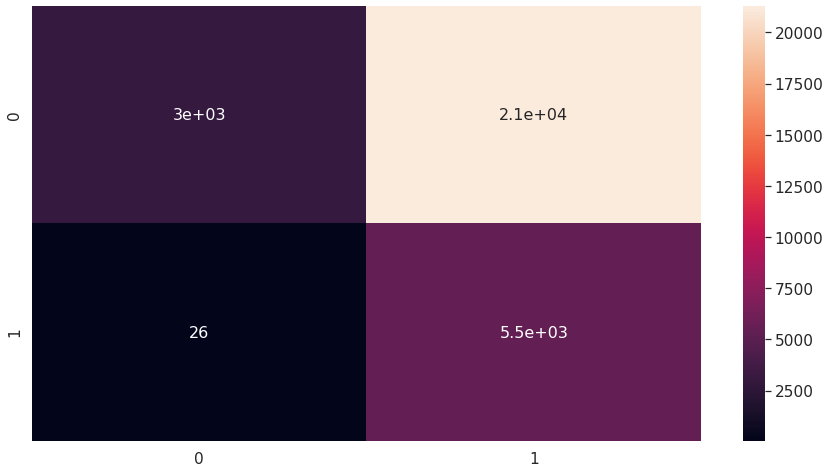

In [ ]:
# Plot the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()